In [ ]:
import os
os.chdir('C:/AI Resume Matcher')
import pandas as pd
import numpy as np
import logging
import sys
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import joblib
# Add project root to path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
from src.preprocessing import preprocess_text
from src.feature_engineering import combine_features, get_tfidf_features
from src.models import train_traditional_models, train_bert, EnsembleModel, MatchDataset
from src.evaluate import evaluate_model
from src.utils import save_model
from sentence_transformers import util
from transformers import RobertaTokenizer, Trainer, RobertaForSequenceClassification
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Evaluation started at 10:15 PM EEST, Thursday, September 25, 2025")

c:\AI Resume Matcher\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:__main__:Evaluation started at 10:15 PM EEST, Thursday, September 25, 2025


In [2]:
# Load test data
test_df = pd.read_csv('data/processed/test_clean.csv')

# Verify required columns
required_columns = ['cv_final', 'jd_final', 'ai_prediction']
missing_cols = [col for col in required_columns if col not in test_df.columns]
if missing_cols:
    logger.warning(f"Test data missing columns: {missing_cols}")

# Create combined text
def create_combined_text(df, cv_col='cv_final', jd_col='jd_final'):
    cv_text = df[cv_col].fillna('')
    jd_text = df[jd_col].fillna('')
    return cv_text + ' [SEP] ' + jd_text

test_texts = create_combined_text(test_df)
test_labels = test_df['ai_prediction'].values

logger.info(f"Test data shape: {test_df.shape}")
logger.info(f"Label distribution in test: {np.bincount(test_labels)}")

INFO:__main__:Test data shape: (654, 10)
INFO:__main__:Label distribution in test: [338 316]


In [ ]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
# Load saved models and features
best_traditional_model = joblib.load('models/best_traditional.pkl')
feats = {'tfidf': joblib.load('models/tfidf.pkl')}
sentence_model = SentenceTransformer('models/sentence_model')
bert_trainer = Trainer(model=RobertaForSequenceClassification.from_pretrained('models/bert_model'))
tokenizer = RobertaTokenizer.from_pretrained('models/bert_model')
logger.info("Models loaded successfully.")
# Reconstruct Ensemble Model
ensemble_model = EnsembleModel(best_traditional_model, bert_trainer, tokenizer)
# Generate test features using the preloaded TF-IDF vectorizer and similarity features
from src.feature_engineering import FeatureEngineer
fe = FeatureEngineer()
test_tfidf = feats['tfidf'].transform(test_texts)  # TF-IDF features (e.g., 4295 in test data)
similarity_features = fe.create_similarity_features(test_texts, test_texts)  # Similarity features
test_tfidf_combined = hstack([test_tfidf, csr_matrix(similarity_features)])  # Combine features

# Pad or truncate to match the expected 25806 features
expected_features = best_traditional_model.n_features_in_  # Should be 25806
if test_tfidf_combined.shape[1] < expected_features:
    padding_size = expected_features - test_tfidf_combined.shape[1]
    padding = csr_matrix((test_tfidf_combined.shape[0], padding_size))
    test_tfidf_combined = hstack([test_tfidf_combined, padding])
elif test_tfidf_combined.shape[1] > expected_features:
    test_tfidf_combined = test_tfidf_combined[:, :expected_features]

test_predictions = ensemble_model.predict(test_tfidf_combined, test_texts.tolist())
logger.info("Predictions made on test set.")
# Save predictions
test_df['predictions'] = test_predictions
test_df.to_csv('data/processed/test_predictions.csv', index=False)
logger.info("✅ Test predictions saved to data/processed/test_predictions.csv")

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: models/sentence_model
INFO:__main__:Models loaded successfully.
c:\AI Resume Matcher\env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


INFO:__main__:Predictions made on test set.
INFO:__main__:✅ Test predictions saved to data/processed/test_predictions.csv



Model - ENHANCED EVALUATION
Accuracy:      0.7920 (79.2%)
Precision:     0.8285
Recall:        0.7184
F1 Score:      0.7695
Specificity:   0.8609
Balanced Acc:  0.7897
📊 Gap to target: 10.8% (Current: 79.2%, Target: 90%)

Confusion Matrix:
              Predicted
           No Match  Match
No Match       291      47
Match           89     227

Error Analysis:
Total samples: 654
Correct: 518 (79.2%)
False Positives: 47 (7.2%)
False Negatives: 89 (13.6%)
⚠️  Consider reducing false positives
⚠️  Consider reducing false negatives

Evaluation Metrics:
              precision    recall  f1-score   support

    No Match       0.77      0.86      0.81       338
       Match       0.83      0.72      0.77       316

    accuracy                           0.79       654
   macro avg       0.80      0.79      0.79       654
weighted avg       0.80      0.79      0.79       654



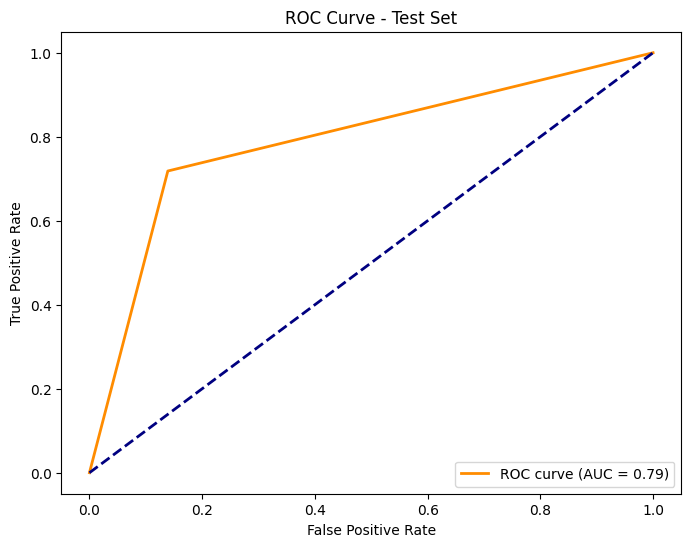

In [ ]:
# Evaluate model
metrics = evaluate_model(test_labels, test_predictions)
print("\nEvaluation Metrics:")
print(classification_report(test_labels, test_predictions, target_names=['No Match', 'Match']))
# Plot ROC
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve - Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Summary of Results
print("\nSummary of Test Results:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
# Optional: Compare with validation set
val_df = pd.read_csv('data/processed/val_clean.csv')
val_texts = create_combined_text(val_df)
val_labels = val_df['ai_prediction'].values
val_tfidf = feats['tfidf'].transform(val_texts)  # TF-IDF features
val_similarity_features = fe.create_similarity_features(val_texts, val_texts)  # Similarity features
val_tfidf_combined = hstack([val_tfidf, csr_matrix(val_similarity_features)])  # Combine features

# Pad or truncate to match the expected 25806 features
if val_tfidf_combined.shape[1] < expected_features:
    padding_size = expected_features - val_tfidf_combined.shape[1]
    padding = csr_matrix((val_tfidf_combined.shape[0], padding_size))
    val_tfidf_combined = hstack([val_tfidf_combined, padding])
elif val_tfidf_combined.shape[1] > expected_features:
    val_tfidf_combined = val_tfidf_combined[:, :expected_features]

val_predictions = ensemble_model.predict(val_tfidf_combined, val_texts.tolist())
val_metrics = evaluate_model(val_labels, val_predictions)
print("\nValidation Metrics for Comparison:")
print(f"Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Precision: {val_metrics['precision']:.4f}")
print(f"Recall: {val_metrics['recall']:.4f}")


Summary of Test Results:
Accuracy: 0.7920
Precision: 0.8285
Recall: 0.7184


c:\AI Resume Matcher\env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Model - ENHANCED EVALUATION
Accuracy:      0.8178 (81.8%)
Precision:     0.8082
Recall:        0.8159
F1 Score:      0.8120
Specificity:   0.8195
Balanced Acc:  0.8177
📊 Gap to target: 8.2% (Current: 81.8%, Target: 90%)

Confusion Matrix:
              Predicted
           No Match  Match
No Match       277      61
Match           58     257

Error Analysis:
Total samples: 653
Correct: 534 (81.8%)
False Positives: 61 (9.3%)
False Negatives: 58 (8.9%)
⚠️  Consider reducing false positives
⚠️  Consider reducing false negatives

Validation Metrics for Comparison:
Accuracy: 0.8178
Precision: 0.8082
Recall: 0.8159
